**Problem 2 c) DermaMNIST  -  Grad-CAM**

###### using the CNN model with Augmentation from 2a

In [1]:
!pip install opencv-python

In [2]:
# Install medmnist
!pip install medmnist

# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from medmnist import DermaMNIST
import torchvision.transforms as transforms
import cv2


2025-03-22 02:16:08.303072: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-22 02:16:08.313767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742609768.326676  335978 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742609768.330386  335978 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742609768.339692  335978 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
# Loading the dataset
train_dataset = DermaMNIST(split="train", download=True)
val_dataset = DermaMNIST(split="val", download=True)
test_dataset = DermaMNIST(split="test", download=True)


Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz
Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz
Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz


In [4]:
# Original labels - Before one-hot encoding
print("Original label shape:", train_dataset.labels.shape)
print("First 5 labels:", train_dataset.labels[:5].flatten())

# labels shape - After one-hot encoding
labels_encoded = tf.keras.utils.to_categorical(train_dataset.labels, num_classes=7)
print("One-hot encoded label shape:", labels_encoded.shape)
print("First 5 one-hot encoded labels:\n", labels_encoded[:5])



Original label shape: (7007, 1)
First 5 labels: [0 5 5 5 4]
One-hot encoded label shape: (7007, 7)
First 5 one-hot encoded labels:
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [5]:
# Normalization
def prepare_data(dataset):
    images = dataset.imgs / 255.0  
    labels = tf.keras.utils.to_categorical(dataset.labels, num_classes=7)
    return images, labels

x_train, y_train = prepare_data(train_dataset)
x_val, y_val = prepare_data(val_dataset)
x_test, y_test = prepare_data(test_dataset)


In [6]:
from sklearn.utils import class_weight

# Converting the one-hot encoded values to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.390350877192983, 1: 2.788300835654596, 2: 1.3016905071521456, 3: 12.5125, 4: 1.2849807445442876, 5: 0.21329639889196675, 6: 10.11111111111111}


In [7]:
# Model 
def build_model():
    model = models.Sequential([
        # 1st Conv Layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # 2nd Conv Layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # 3rd Conv Layer
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        # layers.GlobalAveragePooling2D(), 
        layers.MaxPooling2D(),  
        layers.Dropout(0.4),

    # 4th Conv Layer 
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        
        layers.Flatten(),
        
    # Fully Connected Layers (3 Layers)
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(7, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# using various image aug techniques
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,      
    zoom_range=0.2,        
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen.fit(x_train)

#  model with augmentation  - 150 epochs
aug_model = build_model()
aug_history = aug_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=150,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)



Epoch 1/150


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-22 02:16:11.788977: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 6s - 52ms/step - accuracy: 0.6418 - loss: 1.0746 - val_accuracy: 0.1097 - val_loss: 2.2207
Epoch 2/150
110/110 - 4s - 36ms/step - accuracy: 0.6772 - loss: 0.9254 - val_accuracy: 0.1117 - val_loss: 2.2126
Epoch 3/150
110/110 - 5s - 47ms/step - accuracy: 0.6870 - loss: 0.8787 - val_accuracy: 0.1615 - val_loss: 1.7054
Epoch 4/150
110/110 - 4s - 36ms/step - accuracy: 0.6927 - loss: 0.8564 - val_accuracy: 0.3988 - val_loss: 1.3819
Epoch 5/150
110/110 - 4s - 37ms/step - accuracy: 0.6936 - loss: 0.8527 - val_accuracy: 0.6261 - val_loss: 1.0345
Epoch 6/150
110/110 - 4s - 36ms/step - accuracy: 0.6983 - loss: 0.8214 - val_accuracy: 0.7069 - val_loss: 0.7952
Epoch 7/150
110/110 - 4s - 36ms/step - accuracy: 0.7046 - loss: 0.8006 - val_accuracy: 0.6680 - val_loss: 1.0600
Epoch 8/150
110/110 - 4s - 36ms/step - accuracy: 0.7062 - loss: 0.8076 - val_accuracy: 0.6760 - val_loss: 1.0188
Epoch 9/150
110/110 - 5s - 47ms/step - accuracy: 0.7099 - loss: 0.7863 - val_accuracy: 0.7059 - val_loss: 0.

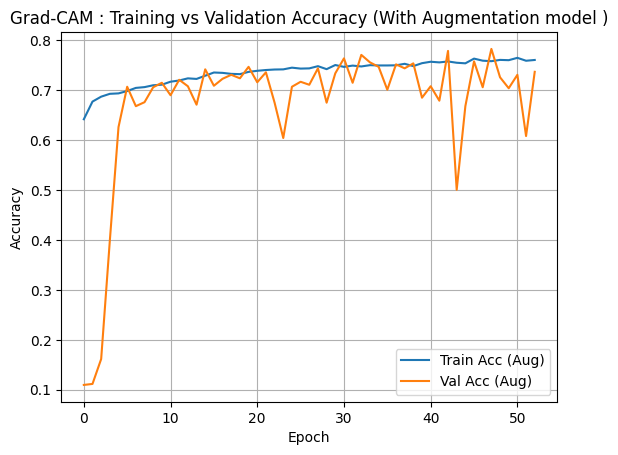

In [8]:
# Learning Curves (
plt.plot(aug_history.history['accuracy'], label='Train Acc (Aug)')
plt.plot(aug_history.history['val_accuracy'], label='Val Acc (Aug)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grad-CAM : Training vs Validation Accuracy (With Augmentation model )')
plt.legend()
plt.grid(True)
plt.show() 


In [9]:
#model's summary

aug_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,467,863 (5.60 MB)

 Trainable params: 488,967 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 977,936 (3.73 MB)

In [10]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_true = np.argmax(y_test, axis=1)
y_aug_pred = aug_model.predict(x_test)
y_aug_pred_classes = np.argmax(y_aug_pred, axis=1)
aug_test_loss, aug_test_acc = aug_model.evaluate(x_test, y_test, verbose=0)

# Evaluation metrics
print("\n--- Metrics WITH Augmentation ---")
print(f"Test Loss: {aug_test_loss:.5f}")
print(f"Test Accuracy: {aug_test_acc:.5f}")
print(f"F1 Score: {f1_score(y_true, y_aug_pred_classes, average='weighted'):.5f}")
print(f"Precision: {precision_score(y_true, y_aug_pred_classes, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_true, y_aug_pred_classes, average='weighted'):.5f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Metrics WITH Augmentation ---
Test Loss: 0.62671
Test Accuracy: 0.76110
F1 Score: 0.73782
Precision: 0.73462
Recall: 0.76110


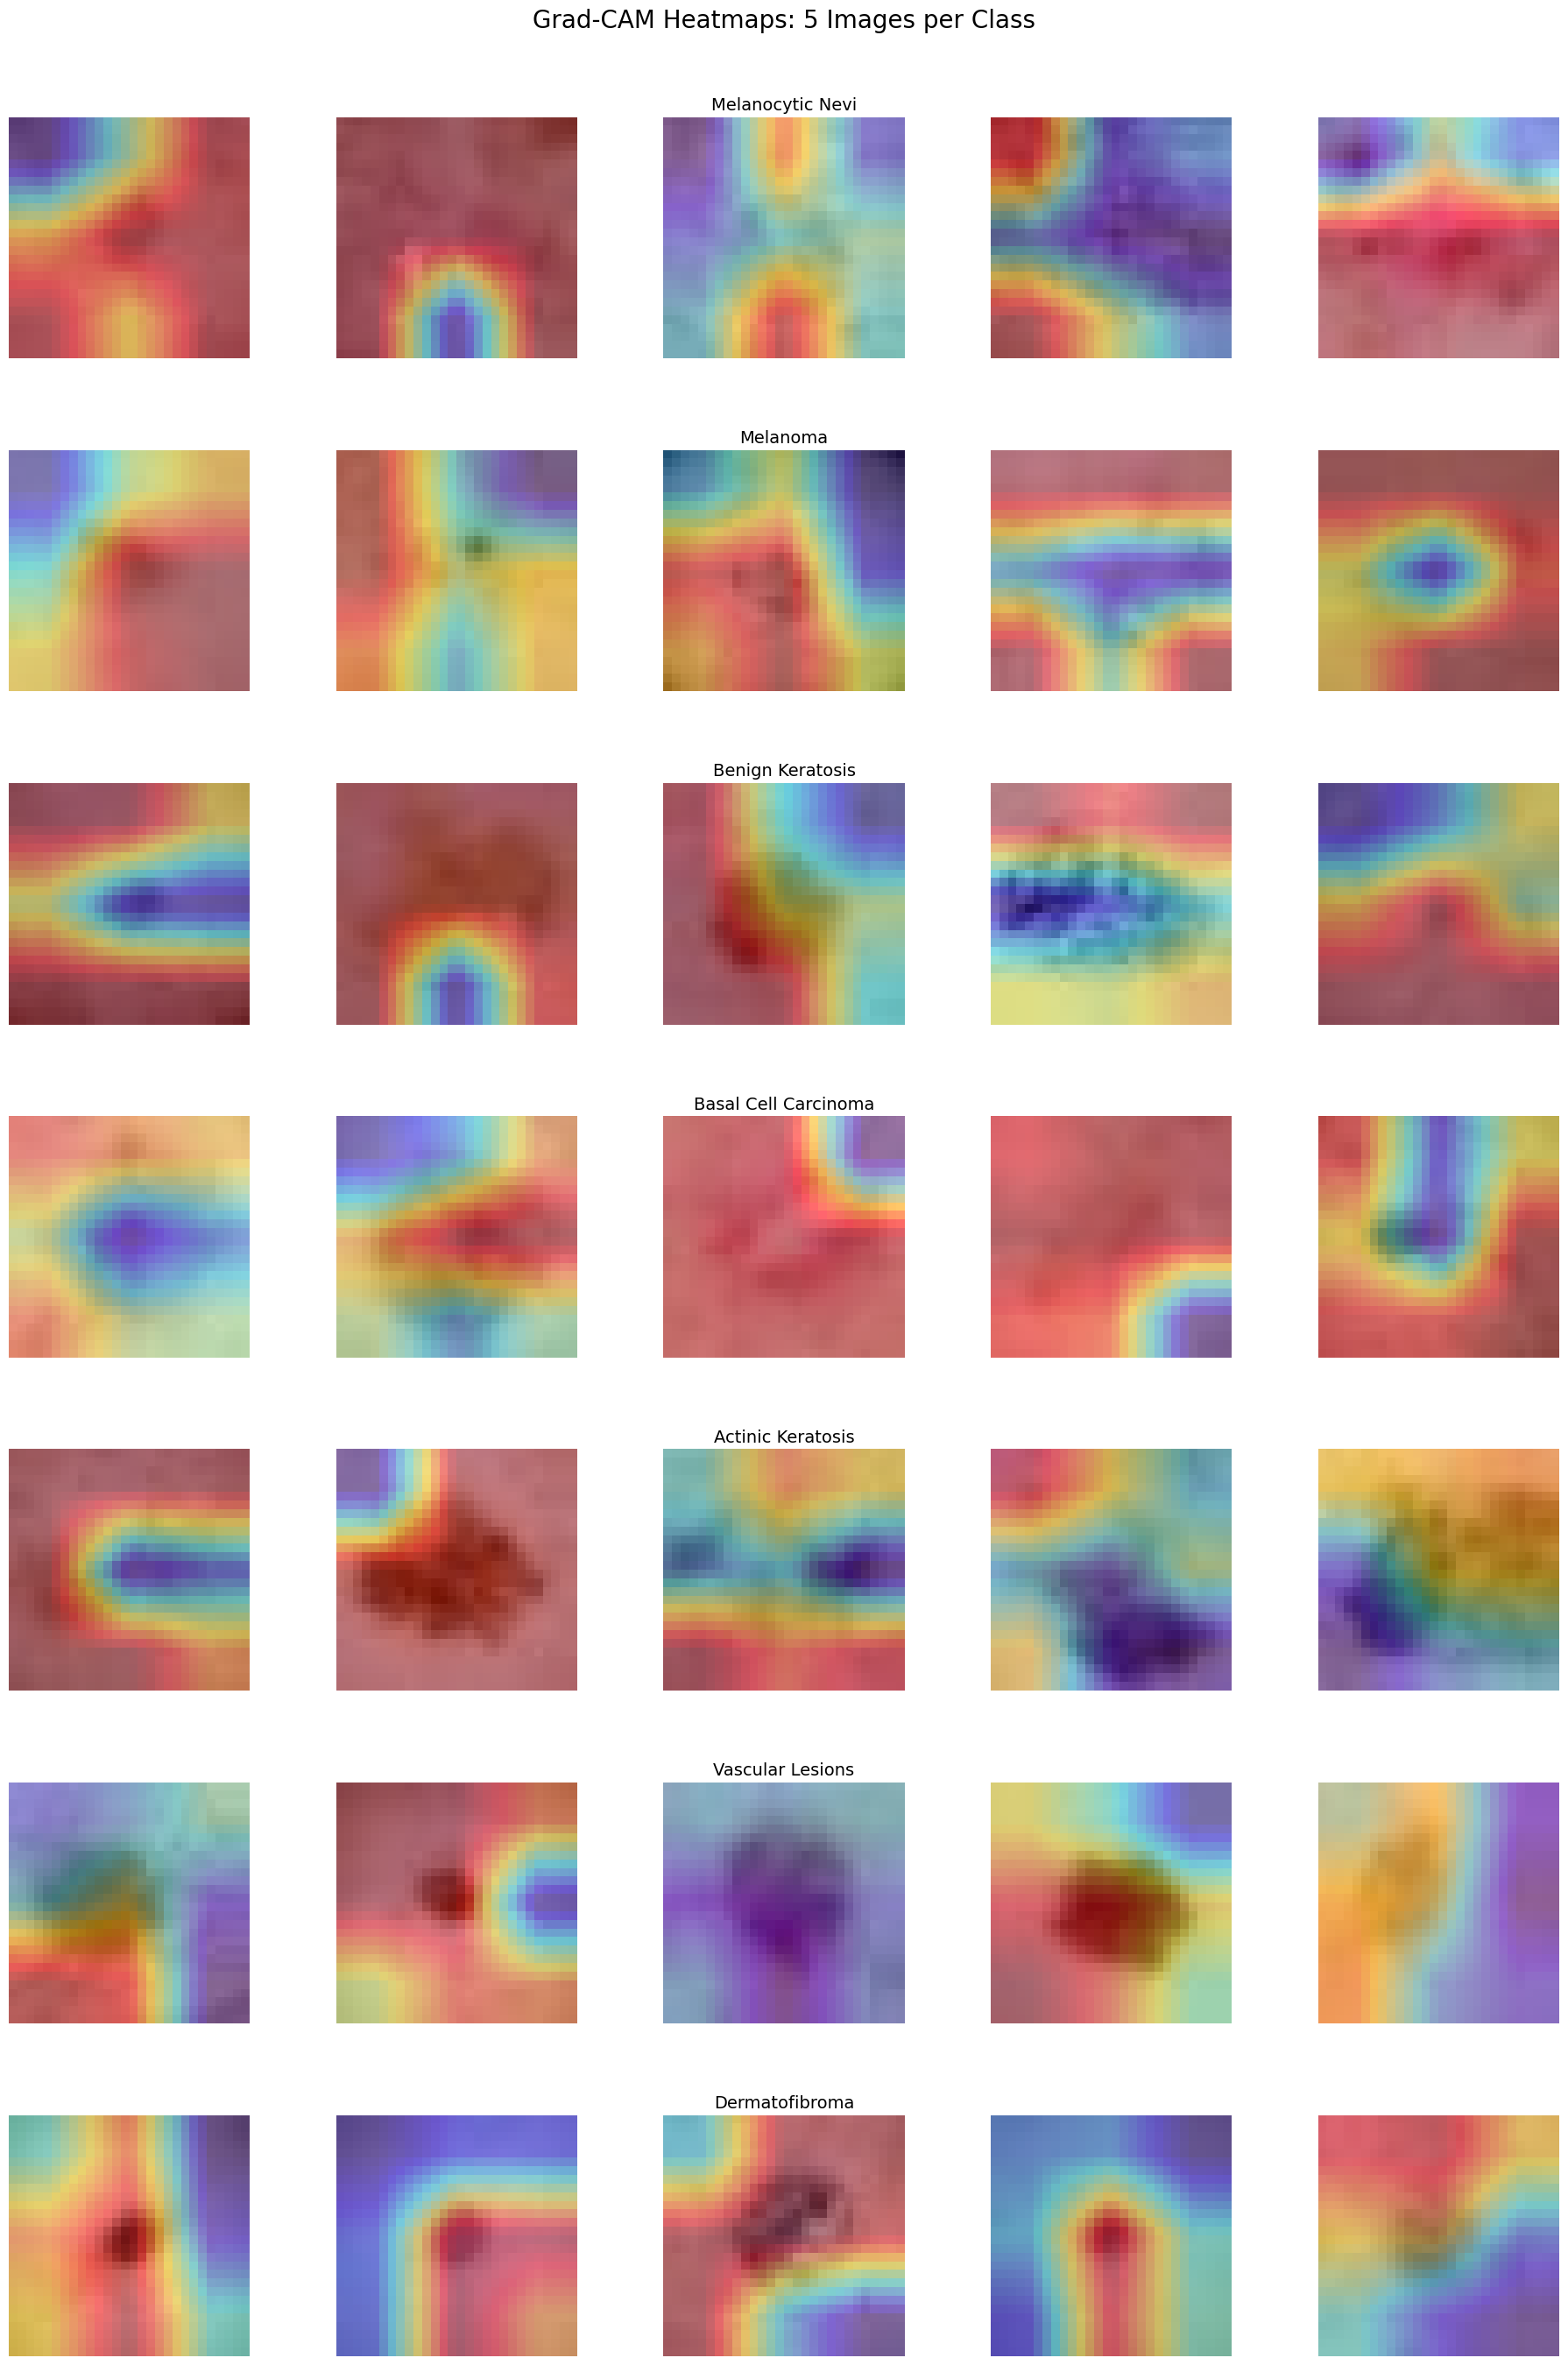

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

# Grad-CAM function
def get_gradcam_heatmap(model, img_array, layer_index):
    grad_model = Model(
        inputs=model.layers[0].input,
        outputs=[model.layers[layer_index].output, model.layers[-1].output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap
def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    color_map = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(color_map, alpha, np.uint8(img * 255), 1 - alpha, 0)
    return overlayed

# Skin class names
skin_classes = {
    0: "Melanocytic Nevi",
    1: "Melanoma",
    2: "Benign Keratosis",
    3: "Basal Cell Carcinoma",
    4: "Actinic Keratosis",
    5: "Vascular Lesions",
    6: "Dermatofibroma"
}

# Grad-CAM visualization
fig, axs = plt.subplots(7, 1, figsize=(18, 30))
fig.suptitle('Grad-CAM Heatmaps: 5 Images per Class', fontsize=20, y=0.92)

layer_index = 10  # Make sure this is correct
samples_per_class = 5
class_images = {i: [] for i in range(7)}

for idx in range(len(x_test)):
    class_id = np.argmax(y_test[idx])
    if len(class_images[class_id]) >= samples_per_class:
        continue

    img = x_test[idx]
    img_input = np.expand_dims(img, axis=0)

    heatmap = get_gradcam_heatmap(aug_model, img_input, layer_index)
    cam = overlay_heatmap(img, heatmap)

    class_images[class_id].append(cam)

spacing = 10
for class_id in range(7):
    spaced_imgs = np.ones((class_images[class_id][0].shape[0], spacing, 3), dtype=np.uint8) * 255
    concatenated_imgs = class_images[class_id][0]

    for img in class_images[class_id][1:]:
        concatenated_imgs = np.hstack((concatenated_imgs, spaced_imgs, img))

    axs[class_id].imshow(concatenated_imgs)
    axs[class_id].axis('off')
    axs[class_id].set_title(skin_classes[class_id], fontsize=14)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


Interpretation:
- The Grad-CAM i.e. the **Gradient-weighted Class Activation Mapping** technique visually highlights areas of an image that most significantly influence a CNN's classification decision.
- This techniques utilizes gradients flowing into the final convolutional layer to generate heatmaps, illustrating the model's focus regions.
- The colors in the Grad-CAM heatmaps represent the intensity of the model's attention:
- The Red and Yellow (warm colors) show that areas of high attention, meaning these regions strongly influenced the model's prediction.
- The Blue and Purple (cool colors) represent the areas of low attention, meaning the model considered these areas less important for its decision.
- The heatmaps per class generated above typically show the areas such as like lesion borders, abnormal pigmentation patterns, and unique textures.
- For eg, in Melanoma and Melanocytic Nevi the model emphasizes irregular edges and varied pigment distributions—critical indicators of malignancy.
- In contrast, for conditions like Benign Keratosis or Basal Cell Carcinoma, the focus is on textures and structural patterns, telling that the model in able to differentiate between benign and malignant lesions based on dermatological features.

#### Hyperparameters used
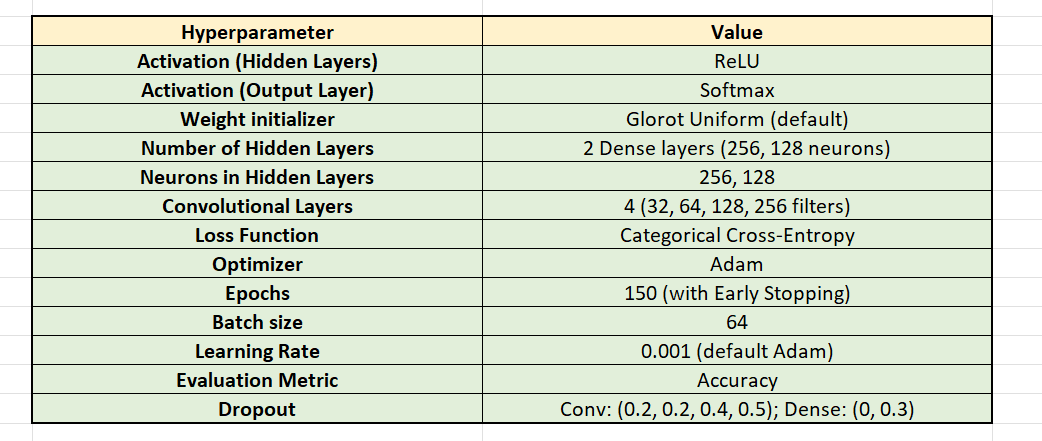